# XGBoost Stock Price Prediction
PostgreSQL Database as Data Source

In [1]:
# Install dependencies (run once)
%pip install pandas numpy scikit-learn xgboost joblib psycopg2-binary sqlalchemy matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sqlalchemy import create_engine, text
import warnings
warnings.filterwarnings('ignore')

## Configuration

In [3]:
# ===== DATABASE CONFIGURATION =====
DB_CONFIG = {
    'host': 'localhost',
    'port': 5432,
    'database': 'market_data',
    'user': 'mluser',
    'password': 'mlpassword'
}

# Stock ticker to train on (table name in market schema)
STOCK_TICKER = 'aapl'

# ===== MODEL CONFIGURATION =====
PREDICTION_HORIZON = 60  # Predict N periods ahead
TRAIN_RATIO = 0.8  # 80% train, 20% test
OUTPUT_DIR = './model_artifacts'  # Where to save model

# XGBoost Parameters
XGB_PARAMS = {
    'n_estimators': 300,
    'max_depth': 100,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',
    'alpha': 10,
    'tree_method': 'hist',  # Use 'hist' for CPU
    # 'device': 'cuda',  # Uncomment for GPU
    'random_state': 42,
}

## Database Connection

In [6]:
# Create database connection
def get_db_engine():
    """Create SQLAlchemy engine for PostgreSQL connection."""
    connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
    return create_engine(connection_string)

def get_available_stocks(engine):
    """Get list of available stock tables in the market schema."""
    query = """
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'market' 
    ORDER BY table_name
    """
    with engine.connect() as conn:
        result = pd.read_sql(query, conn)
    return result['table_name'].tolist()

def load_stock_data(engine, ticker):
    """Load stock data from PostgreSQL database."""
    query = f'SELECT * FROM market."{ticker}" ORDER BY date'
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    return df

# Test connection
engine = get_db_engine()
print("Database connection established!")

# List available stocks
stocks = get_available_stocks(engine)
print(f"\nAvailable stocks: {len(stocks)}")
print(f"First 20: {stocks[:20]}")
print(f"...\nLast 10: {stocks[-10:]}")

Database connection established!

Available stocks: 517
First 20: ['a', 'aapl', 'abbv', 'abcde', 'abnb', 'abt', 'acgl', 'acn', 'adbe', 'adi', 'adm', 'adp', 'adsk', 'aee', 'aep', 'aes', 'afl', 'aig', 'aiz', 'ajg']
...
Last 10: ['wy', 'wynn', 'xel', 'xom', 'xyl', 'xyz', 'yum', 'zbh', 'zbra', 'zts']


## Exploratory Data Analysis (EDA)

In [ ]:
# Load sample data for EDA
eda_df = load_stock_data(engine, STOCK_TICKER)
print(f"=== {STOCK_TICKER.upper()} Data Overview ===")
print(f"Total rows: {len(eda_df):,}")
print(f"\nColumns: {eda_df.columns.tolist()}")
print(f"\nData types:\n{eda_df.dtypes}")
print(f"\nFirst 5 rows:")
eda_df.head()

In [ ]:
# Statistical summary
eda_df['date'] = pd.to_datetime(eda_df['date'])
print("=== Statistical Summary (OHLCV) ===")
print(eda_df[['open', 'high', 'low', 'close', 'volume']].describe())

print(f"\n=== Date Range ===")
print(f"Start: {eda_df['date'].min()}")
print(f"End:   {eda_df['date'].max()}")
print(f"Duration: {(eda_df['date'].max() - eda_df['date'].min()).days} days")

print(f"\n=== Missing Values ===")
print(eda_df.isnull().sum())

In [ ]:
# EDA Visualizations
import matplotlib.pyplot as plt

eda_df_sorted = eda_df.sort_values('date')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Price over time
ax1 = axes[0, 0]
ax1.plot(eda_df_sorted['date'], eda_df_sorted['close'], linewidth=0.5)
ax1.set_title(f'{STOCK_TICKER.upper()} Close Price Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# 2. Volume over time
ax2 = axes[0, 1]
ax2.plot(eda_df_sorted['date'], eda_df_sorted['volume'], linewidth=0.3, alpha=0.7)
ax2.set_title('Trading Volume Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.grid(True, alpha=0.3)

# 3. Price distribution
ax3 = axes[1, 0]
ax3.hist(eda_df_sorted['close'], bins=50, edgecolor='black', alpha=0.7)
ax3.set_title('Close Price Distribution')
ax3.set_xlabel('Price ($)')
ax3.set_ylabel('Frequency')

# 4. Daily returns distribution
returns = eda_df_sorted['close'].pct_change().dropna()
ax4 = axes[1, 1]
ax4.hist(returns, bins=100, edgecolor='black', alpha=0.7)
ax4.set_title('Returns Distribution (5-min)')
ax4.set_xlabel('Return')
ax4.set_ylabel('Frequency')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print(f"\nReturns Statistics:")
print(f"  Mean:   {returns.mean()*100:.4f}%")
print(f"  Std:    {returns.std()*100:.4f}%")
print(f"  Min:    {returns.min()*100:.4f}%")
print(f"  Max:    {returns.max()*100:.4f}%")

## Feature Engineering Functions

In [ ]:
def create_technical_features(df):
    """
    Create technical indicator features from OHLCV data.
    """
    df = df.copy()

    # --- Basic Price Features ---
    df['return_1'] = df['close'].pct_change(1)
    df['return_5'] = df['close'].pct_change(5)
    df['return_10'] = df['close'].pct_change(10)
    df['return_20'] = df['close'].pct_change(20)

    # --- Moving Averages ---
    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
        df[f'ema_{window}'] = df['close'].ewm(span=window, adjust=False).mean()

    # --- Price relative to MAs ---
    df['close_to_sma_20'] = df['close'] / df['sma_20']
    df['close_to_sma_50'] = df['close'] / df['sma_50']
    df['sma_20_to_sma_50'] = df['sma_20'] / df['sma_50']

    # --- Volatility Features ---
    df['volatility_5'] = df['return_1'].rolling(window=5).std()
    df['volatility_10'] = df['return_1'].rolling(window=10).std()
    df['volatility_20'] = df['return_1'].rolling(window=20).std()

    # --- High-Low Range ---
    df['hl_range'] = (df['high'] - df['low']) / df['close']
    df['hl_range_ma_10'] = df['hl_range'].rolling(window=10).mean()

    # --- Price Position within Range ---
    df['close_position'] = (df['close'] - df['low']) / (df['high'] - df['low'] + 1e-8)

    # --- Open-Close Relationship ---
    df['oc_range'] = (df['close'] - df['open']) / df['open']
    df['body_to_range'] = (df['close'] - df['open']) / (df['high'] - df['low'] + 1e-8)

    # --- Volume Features ---
    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / (df['volume_ma_20'] + 1)
    df['volume_change'] = df['volume'].pct_change(1)

    # --- RSI ---
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-8)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # --- Rate of Change ---
    df['roc_5'] = (df['close'] - df['close'].shift(5)) / df['close'].shift(5)
    df['roc_10'] = (df['close'] - df['close'].shift(10)) / df['close'].shift(10)
    df['roc_20'] = (df['close'] - df['close'].shift(20)) / df['close'].shift(20)

    # --- MACD ---
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    # --- Bollinger Bands ---
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + 2 * bb_std
    df['bb_lower'] = df['bb_middle'] - 2 * bb_std
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'] + 1e-8)

    # --- Lag Features ---
    for lag in [1, 2, 3, 5, 10]:
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
        df[f'return_lag_{lag}'] = df['return_1'].shift(lag)

    # --- Time-based Features ---
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_market_open'] = ((df['hour'] >= 9) & (df['hour'] < 16)).astype(int)

    return df

## Load and Prepare Data

In [ ]:
# Load data from PostgreSQL
print(f"Loading {STOCK_TICKER.upper()} data from database...")
df = load_stock_data(engine, STOCK_TICKER)
print(f"Loaded: {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
df.head()

In [ ]:
# Parse datetime and clean
df['date'] = pd.to_datetime(df['date'])
df = df.drop_duplicates(subset=['date']).reset_index(drop=True)
df = df.sort_values('date').reset_index(drop=True)

# Ensure numeric columns
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"After cleaning: {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

In [ ]:
# Create features
print("Engineering features...")
df = create_technical_features(df)

# Create target (future close price)
df['target'] = df['close'].shift(-PREDICTION_HORIZON)

# Clean up
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna().reset_index(drop=True)
print(f"After cleaning: {len(df)} rows")

Engineering features...
After cleaning: 107253 rows


In [ ]:
# Check features
print(f"Total columns: {len(df.columns)}")
df.head()

Total columns: 61


,date,open,high,low,close,volume,return_1,return_5,return_10,return_20,...,close_lag_3,return_lag_3,close_lag_5,return_lag_5,close_lag_10,return_lag_10,hour,dayofweek,is_market_open,target
0,2023-07-03 12:30:00,192.110,192.140,192.0397,192.0400,347019,-0.000390,-0.000598,-0.000858,0.000951,...,192.210,0.000261,192.1550,-0.000702,192.2050,-0.001221,12,0,1,191.2700
1,2023-07-03 12:35:00,192.040,192.125,192.0100,192.1000,362782,0.000312,-0.000311,-0.001204,0.000630,...,192.120,-0.000468,192.1598,0.000025,192.3316,0.000659,12,0,1,191.1800
2,2023-07-03 12:40:00,192.100,192.330,192.1000,192.2255,550794,0.000653,0.000081,-0.000283,0.001122,...,192.115,-0.000026,192.2100,0.000261,192.2800,-0.000268,12,0,1,191.2900
3,2023-07-03 12:45:00,192.225,192.320,192.1199,192.2450,438549,0.000101,0.000651,0.000078,0.001015,...,192.040,-0.000390,192.1200,-0.000468,192.2300,-0.000260,12,0,1,191.2100
4,2023-07-03 12:50:00,192.250,192.395,192.2250,192.3650,618701,0.000624,0.001301,0.000390,0.000291,...,192.100,0.000312,192.1150,-0.000026,192.2900,0.000312,12,0,1,191.2892


## Prepare Train/Test Split

In [ ]:
# Define feature columns
exclude_cols = ['date', 'target', 'open', 'high', 'low', 'close', 'volume']
feature_cols = [c for c in df.columns if c not in exclude_cols]
print(f"Using {len(feature_cols)} features")
print(feature_cols)

Using 54 features
['return_1', 'return_5', 'return_10', 'return_20', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'close_to_sma_20', 'close_to_sma_50', 'sma_20_to_sma_50', 'volatility_5', 'volatility_10', 'volatility_20', 'hl_range', 'hl_range_ma_10', 'close_position', 'oc_range', 'body_to_range', 'volume_ma_10', 'volume_ma_20', 'volume_ratio', 'volume_change', 'rsi_14', 'roc_5', 'roc_10', 'roc_20', 'macd', 'macd_signal', 'macd_hist', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position', 'close_lag_1', 'return_lag_1', 'close_lag_2', 'return_lag_2', 'close_lag_3', 'return_lag_3', 'close_lag_5', 'return_lag_5', 'close_lag_10', 'return_lag_10', 'hour', 'dayofweek', 'is_market_open']


In [ ]:
# Time-based split
split_idx = int(len(df) * TRAIN_RATIO)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Train: {len(train_df)} rows ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"Test:  {len(test_df)} rows ({test_df['date'].min()} to {test_df['date'].max()})")

Train: 85802 rows (2023-07-03 12:30:00 to 2025-05-08 15:15:00)
Test:  21451 rows (2025-05-08 15:20:00 to 2025-10-24 14:55:00)


In [ ]:
# Prepare X and y
X_train = train_df[feature_cols]
y_train = train_df['target']
X_test = test_df[feature_cols]
y_test = test_df['target']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (85802, 54)
X_test shape: (21451, 54)


In [ ]:
# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

Features scaled


## Train Model

In [ ]:
# Initialize model
model = XGBRegressor(**XGB_PARAMS)
print("Model parameters:")
print(XGB_PARAMS)

Model parameters:
{'n_estimators': 300, 'max_depth': 100, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'alpha': 10, 'tree_method': 'hist', 'random_state': 42}


In [ ]:
# Train
print("Training...")
start_time = time.time()

model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=50
)

train_duration = time.time() - start_time
print(f"\nTraining completed in {train_duration:.2f} seconds")

Training...
[0]	validation_0-rmse:25.95580
[50]	validation_0-rmse:3.05052
[100]	validation_0-rmse:3.03502
[150]	validation_0-rmse:3.03450
[200]	validation_0-rmse:3.03454
[250]	validation_0-rmse:3.03449
[299]	validation_0-rmse:3.03460

Training completed in 314.65 seconds


## Evaluate

In [ ]:
# Predict
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print("=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"Train RMSE: ${train_rmse:.4f}")
print(f"Test RMSE:  ${test_rmse:.4f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test MAPE:  {test_mape:.2f}%")

EVALUATION METRICS
Train RMSE: $0.1435
Test RMSE:  $3.0346
Train MAPE: 0.05%
Test MAPE:  0.98%


In [ ]:
# Results dataframe
results = pd.DataFrame({
    'datetime': test_df['date'].values,
    'actual': y_test.values,
    'predicted': y_pred_test,
    'difference': np.abs(y_test.values - y_pred_test),
})
results.head(10)

,datetime,actual,predicted,difference
0,2025-05-08 15:20:00,197.99,197.961029,0.028971
1,2025-05-08 15:25:00,197.98,198.236374,0.256374
2,2025-05-08 15:30:00,198.07,198.005371,0.064629
3,2025-05-08 15:35:00,198.00,197.363419,0.636581
4,2025-05-08 15:40:00,198.03,197.109497,0.920503
5,2025-05-08 15:45:00,197.94,197.374786,0.565214
6,2025-05-08 15:50:00,197.92,198.911636,0.991636
7,2025-05-08 15:55:00,198.00,199.217819,1.217819
8,2025-05-08 16:00:00,198.04,199.704971,1.664971
9,2025-05-08 16:05:00,198.13,200.066162,1.936162


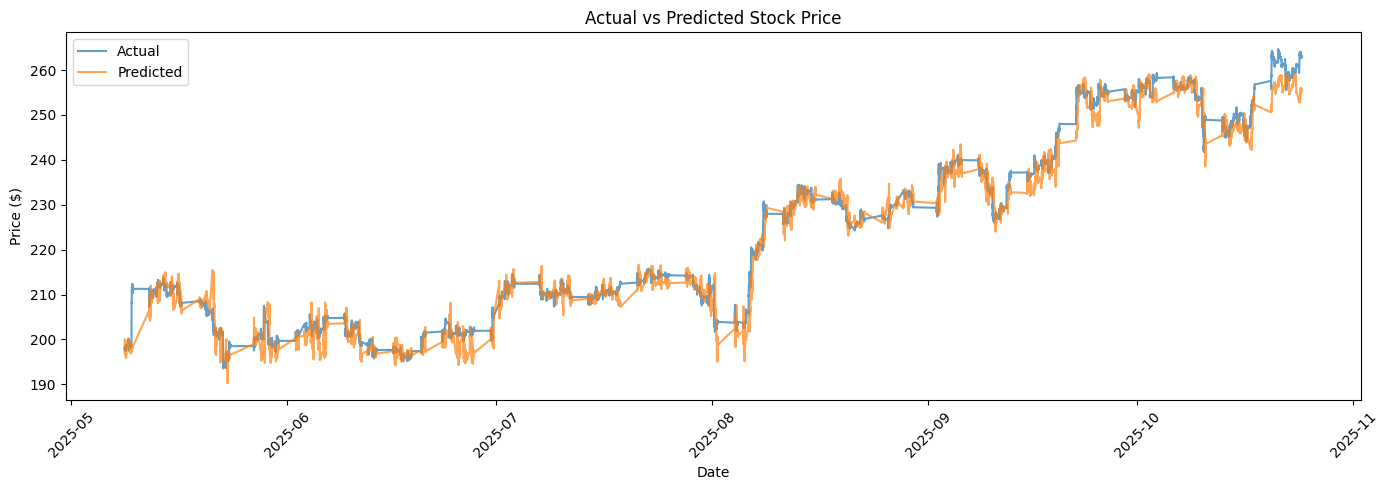

In [ ]:
# Plot (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(results['datetime'], results['actual'], label='Actual', alpha=0.7)
plt.plot(results['datetime'], results['predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ===== FULL DATA + PREDICTIONS PLOT =====
import matplotlib.pyplot as plt

# Use the already loaded df for full history
df_full = load_stock_data(engine, STOCK_TICKER)
df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full.drop_duplicates(subset=['date']).sort_values('date')

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

# Full historical close price
ax.plot(df_full['date'], df_full['close'], label='Historical Close', color='blue', alpha=0.6, linewidth=0.8)

# Actual vs Predicted on test set
ax.plot(results['datetime'], results['actual'], label='Actual (Test)', color='green', linewidth=1.2)
ax.plot(results['datetime'], results['predicted'], label='Predicted (Test)', color='red', linewidth=1.2, linestyle='--')

# Mark train/test split
split_date = results['datetime'].min()
ax.axvline(x=split_date, color='black', linestyle=':', linewidth=1.5, label=f'Train/Test Split')

ax.set_title(f'{STOCK_TICKER.upper()} Stock Price - Full Data with Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Save Model Artifacts

In [ ]:
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save model
model.save_model(f"{OUTPUT_DIR}/xgboost_model.json")
print(f"Model saved: {OUTPUT_DIR}/xgboost_model.json")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/scaler.joblib")
print(f"Scaler saved: {OUTPUT_DIR}/scaler.joblib")

# Save feature names
joblib.dump(feature_cols, f"{OUTPUT_DIR}/feature_names.joblib")
print(f"Feature names saved: {OUTPUT_DIR}/feature_names.joblib")

# Save config
config = {'prediction_horizon': PREDICTION_HORIZON, 'train_ratio': TRAIN_RATIO}
joblib.dump(config, f"{OUTPUT_DIR}/config.joblib")
print(f"Config saved: {OUTPUT_DIR}/config.joblib")

# Save predictions
results.to_csv(f"{OUTPUT_DIR}/predictions.csv", index=False)
print(f"Predictions saved: {OUTPUT_DIR}/predictions.csv")

Model saved: ./model_artifacts/xgboost_model.json
Scaler saved: ./model_artifacts/scaler.joblib
Feature names saved: ./model_artifacts/feature_names.joblib
Config saved: ./model_artifacts/config.joblib
Predictions saved: ./model_artifacts/predictions.csv


## Test Loading Model (for inference)

In [ ]:
# Load and verify
loaded_model = XGBRegressor()
loaded_model.load_model(f"{OUTPUT_DIR}/xgboost_model.json")
loaded_scaler = joblib.load(f"{OUTPUT_DIR}/scaler.joblib")
loaded_features = joblib.load(f"{OUTPUT_DIR}/feature_names.joblib")

# Quick test
test_pred = loaded_model.predict(loaded_scaler.transform(X_test.iloc[:5]))
print("Model loaded successfully!")
print(f"Sample predictions: {test_pred}")

Model loaded successfully!
Sample predictions: [197.96103 198.23637 198.00537 197.36342 197.1095 ]


---
## Done!

**Artifacts saved in `model_artifacts/`:**
- `xgboost_model.json` - trained model
- `scaler.joblib` - feature scaler
- `feature_names.joblib` - feature column names
- `config.joblib` - configuration

Use these in your FastAPI inference service.

In [ ]:
!pip install yfinance

Model loaded!

Fetching AAPL data from 2026-01-25 to 2026-02-04...
Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Shape: (427, 5)
Fetched 427 rows
Date range: 2026-01-26 14:30:00 to 2026-02-03 20:55:00
After feature engineering: 328 rows

MODEL ACCURACY ON REAL DATA
RMSE: $8.16
MAPE: 2.21%

LATEST PREDICTION
Current Date:      2026-02-03 20:55:00
Current Price:     $269.46
Predicted Price:   $256.98 (in 300 minutes)
Expected Change:   $-12.48 (-4.63%)


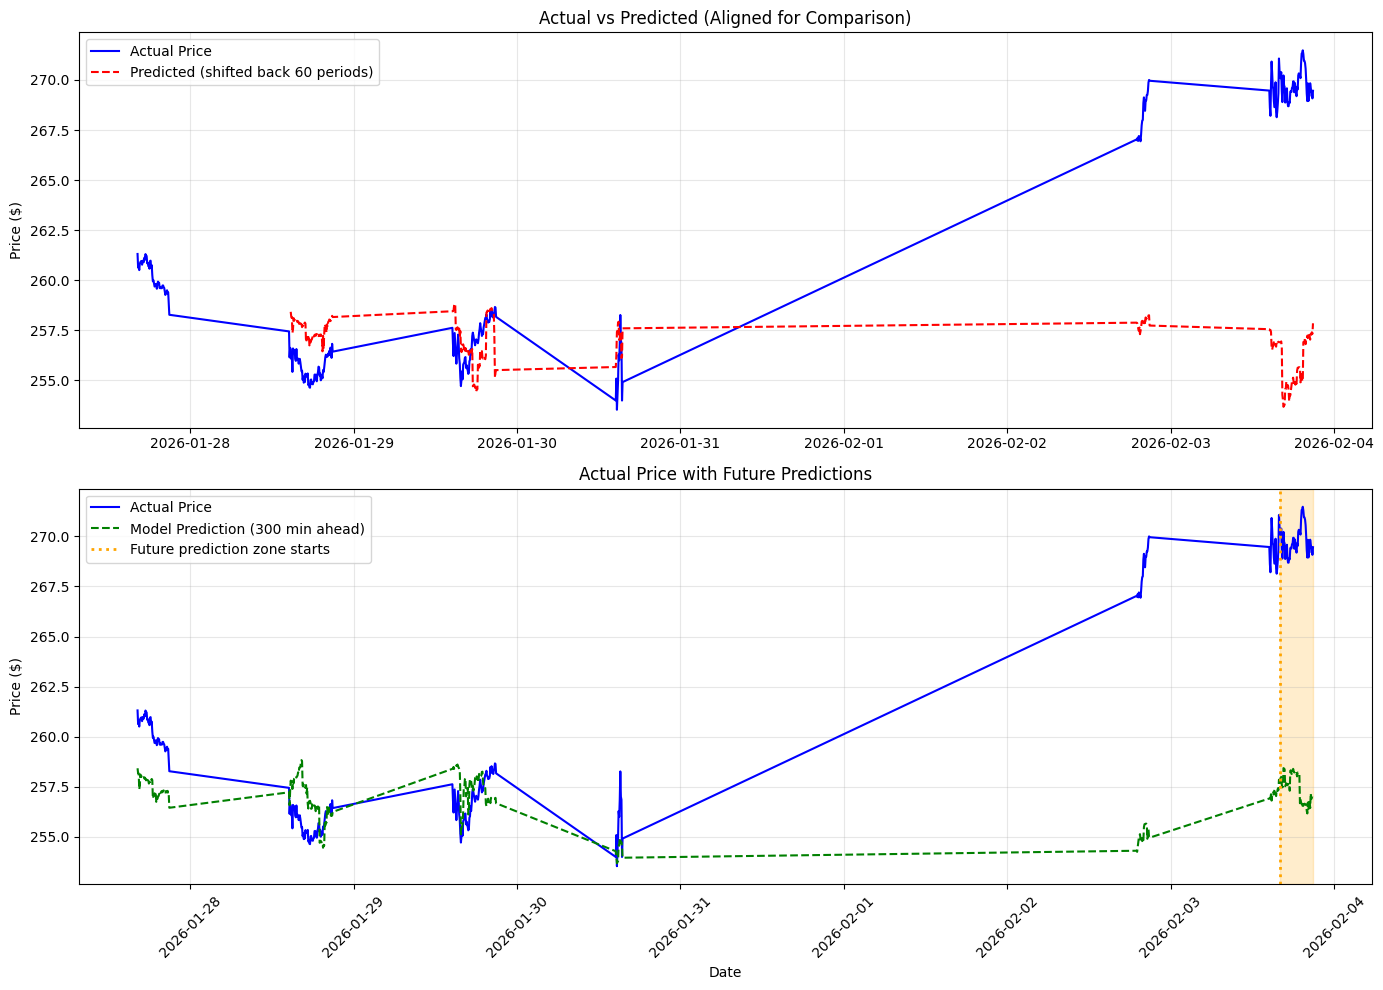


LAST 10 PREDICTIONS
               date      close  predicted     change  change_pct
2026-02-03 20:10:00 269.829987 256.716583 -13.113403   -4.859876
2026-02-03 20:15:00 268.950012 256.387756 -12.562256   -4.670852
2026-02-03 20:20:00 269.200012 256.784119 -12.415894   -4.612144
2026-02-03 20:25:00 269.209991 256.849091 -12.360901   -4.591546
2026-02-03 20:30:00 269.834991 256.442566 -13.392426   -4.963191
2026-02-03 20:35:00 269.600006 257.179779 -12.420227   -4.606909
2026-02-03 20:40:00 269.410004 256.891052 -12.518951   -4.646803
2026-02-03 20:45:00 269.420013 257.076996 -12.343018   -4.581329
2026-02-03 20:50:00 269.079987 257.000458 -12.079529   -4.489196
2026-02-03 20:55:00 269.459991 256.975555 -12.484436   -4.633132


In [ ]:
# ===== FETCH REAL DATA & COMPARE WITH PREDICTIONS =====
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Install yfinance if needed
# !pip install yfinance

# ===== LOAD MODEL ARTIFACTS =====
model = XGBRegressor()
model.load_model("model_artifacts/xgboost_model.json")
scaler = joblib.load("model_artifacts/scaler.joblib")
feature_names = joblib.load("model_artifacts/feature_names.joblib")

print("Model loaded!")

# ===== FETCH REAL DATA FROM YAHOO FINANCE =====
ticker = "AAPL"
end_date = datetime.now()
start_date = end_date - timedelta(days=10)  # Get 10 days for feature calculation buffer

print(f"\nFetching {ticker} data from {start_date.date()} to {end_date.date()}...")
real_data = yf.download(ticker, start=start_date, end=end_date, interval="5m", progress=False)

# Check what we got
print(f"Columns: {real_data.columns.tolist()}")
print(f"Shape: {real_data.shape}")

# Clean up columns (handle both old and new yfinance formats)
real_data = real_data.reset_index()

# Flatten multi-level columns if present
if isinstance(real_data.columns, pd.MultiIndex):
    real_data.columns = [col[0].lower() if col[1] == '' else col[0].lower() for col in real_data.columns]
else:
    real_data.columns = [col.lower() for col in real_data.columns]

# Rename datetime column if needed
if 'datetime' in real_data.columns:
    real_data = real_data.rename(columns={'datetime': 'date'})

# Keep only needed columns
real_data = real_data[['date', 'open', 'high', 'low', 'close', 'volume']]
real_data['date'] = pd.to_datetime(real_data['date']).dt.tz_localize(None)  # Remove timezone

print(f"Fetched {len(real_data)} rows")
print(f"Date range: {real_data['date'].min()} to {real_data['date'].max()}")

# ===== FEATURE ENGINEERING (same as training) =====
def create_technical_features(df):
    df = df.copy()

    df['return_1'] = df['close'].pct_change(1)
    df['return_5'] = df['close'].pct_change(5)
    df['return_10'] = df['close'].pct_change(10)
    df['return_20'] = df['close'].pct_change(20)

    for window in [5, 10, 20, 50, 100]:
        df[f'sma_{window}'] = df['close'].rolling(window=window).mean()
        df[f'ema_{window}'] = df['close'].ewm(span=window, adjust=False).mean()

    df['close_to_sma_20'] = df['close'] / df['sma_20']
    df['close_to_sma_50'] = df['close'] / df['sma_50']
    df['sma_20_to_sma_50'] = df['sma_20'] / df['sma_50']

    df['volatility_5'] = df['return_1'].rolling(window=5).std()
    df['volatility_10'] = df['return_1'].rolling(window=10).std()
    df['volatility_20'] = df['return_1'].rolling(window=20).std()

    df['hl_range'] = (df['high'] - df['low']) / df['close']
    df['hl_range_ma_10'] = df['hl_range'].rolling(window=10).mean()
    df['close_position'] = (df['close'] - df['low']) / (df['high'] - df['low'] + 1e-8)
    df['oc_range'] = (df['close'] - df['open']) / df['open']
    df['body_to_range'] = (df['close'] - df['open']) / (df['high'] - df['low'] + 1e-8)

    df['volume_ma_10'] = df['volume'].rolling(window=10).mean()
    df['volume_ma_20'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / (df['volume_ma_20'] + 1)
    df['volume_change'] = df['volume'].pct_change(1)

    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-8)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    df['roc_5'] = (df['close'] - df['close'].shift(5)) / df['close'].shift(5)
    df['roc_10'] = (df['close'] - df['close'].shift(10)) / df['close'].shift(10)
    df['roc_20'] = (df['close'] - df['close'].shift(20)) / df['close'].shift(20)

    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + 2 * bb_std
    df['bb_lower'] = df['bb_middle'] - 2 * bb_std
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'] + 1e-8)

    for lag in [1, 2, 3, 5, 10]:
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
        df[f'return_lag_{lag}'] = df['return_1'].shift(lag)

    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_market_open'] = ((df['hour'] >= 9) & (df['hour'] < 16)).astype(int)

    df = df.replace([np.inf, -np.inf], np.nan)
    return df

# ===== PREPARE DATA & PREDICT =====
real_data = create_technical_features(real_data)
real_data_clean = real_data.dropna().reset_index(drop=True)

print(f"After feature engineering: {len(real_data_clean)} rows")

# Make predictions for all points
X_real = real_data_clean[feature_names]
X_real_scaled = scaler.transform(X_real)
predictions = model.predict(X_real_scaled)

real_data_clean['predicted'] = predictions

# ===== SHIFT PREDICTIONS TO ALIGN WITH ACTUAL (for comparison) =====
HORIZON = 60
real_data_clean['predicted_aligned'] = real_data_clean['predicted'].shift(HORIZON)

# ===== CALCULATE ACCURACY ON REAL DATA =====
compare_df = real_data_clean.dropna(subset=['predicted_aligned'])
if len(compare_df) > 0:
    mape = np.mean(np.abs((compare_df['close'] - compare_df['predicted_aligned']) / compare_df['close'])) * 100
    rmse = np.sqrt(np.mean((compare_df['close'] - compare_df['predicted_aligned'])**2))
    print(f"\n{'='*50}")
    print("MODEL ACCURACY ON REAL DATA")
    print(f"{'='*50}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

# ===== LATEST PREDICTION =====
latest = real_data_clean.iloc[-1]
print(f"\n{'='*50}")
print("LATEST PREDICTION")
print(f"{'='*50}")
print(f"Current Date:      {latest['date']}")
print(f"Current Price:     ${latest['close']:.2f}")
print(f"Predicted Price:   ${latest['predicted']:.2f} (in {HORIZON*5} minutes)")
change = latest['predicted'] - latest['close']
change_pct = (change / latest['close']) * 100
print(f"Expected Change:   ${change:+.2f} ({change_pct:+.2f}%)")

# ===== PLOT: ACTUAL vs PREDICTED =====
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Actual prices with aligned predictions
ax1 = axes[0]
ax1.plot(real_data_clean['date'], real_data_clean['close'], label='Actual Price', color='blue', linewidth=1.5)
ax1.plot(real_data_clean['date'], real_data_clean['predicted_aligned'], label=f'Predicted (shifted back {HORIZON} periods)', color='red', linewidth=1.5, linestyle='--')
ax1.set_title('Actual vs Predicted (Aligned for Comparison)')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Actual with future predictions
ax2 = axes[1]
ax2.plot(real_data_clean['date'], real_data_clean['close'], label='Actual Price', color='blue', linewidth=1.5)
ax2.plot(real_data_clean['date'], real_data_clean['predicted'], label=f'Model Prediction ({HORIZON*5} min ahead)', color='green', linewidth=1.5, linestyle='--')
future_start = real_data_clean['date'].iloc[-HORIZON] if len(real_data_clean) > HORIZON else real_data_clean['date'].iloc[0]
ax2.axvline(x=future_start, color='orange', linestyle=':', linewidth=2, label='Future prediction zone starts')
ax2.axvspan(future_start, real_data_clean['date'].iloc[-1], alpha=0.2, color='orange')
ax2.set_title('Actual Price with Future Predictions')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== TABLE: LAST 10 PREDICTIONS =====
print(f"\n{'='*50}")
print("LAST 10 PREDICTIONS")
print(f"{'='*50}")
last_10 = real_data_clean[['date', 'close', 'predicted']].tail(10).copy()
last_10['change'] = last_10['predicted'] - last_10['close']
last_10['change_pct'] = (last_10['change'] / last_10['close']) * 100
print(last_10.to_string(index=False))